In [9]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

In [10]:
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

In [11]:
class TemplateOutputState(TypedDict):
    processed_logs: List[str]

class TemplateState(TypedDict):
    cleaned_logs: List[Log]

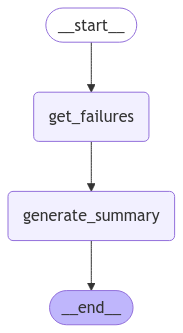

In [12]:
# FAILURE ANALYSIS GRAPH
class FailureAnalysisOutputState(TemplateOutputState):
    fa_summary: str

class FailureAnalysisState(FailureAnalysisOutputState, TemplateState):
    failures: List[Log]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failure """
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(FailureAnalysisState, input=FailureAnalysisState, output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

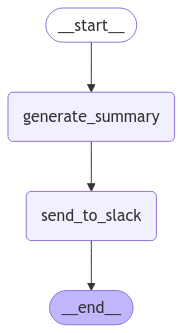

In [15]:
class QuestionSummarizationOutputState(TemplateOutputState):
    report: str

class QuestionSummarizationState(QuestionSummarizationOutputState, TemplateState):
    qs_summary: str

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on the usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report =  "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState, input=QuestionSummarizationState, output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


# PARENT GRAPH

In [ ]:
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str
    report: str
    processed_logs: Annotated[List[str], add]

def clean_logs(state):
    raw_logs = state["raw_logs"]
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))